# Setup/imports

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning,
                        message=r"Using \d+ background data samples could cause slower run times.*")
warnings.filterwarnings("ignore", category=UserWarning,
                        message=r"X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names")
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
from load_dataset import *
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr, kendalltau

import shap
from lime.lime_tabular import LimeTabularExplainer

from IPython.display import display, Markdown
from tqdm.notebook import tqdm



# Load data

In [3]:
adult_X, adult_y = load_adult()
housing_X, housing_y = load_housing()

In [4]:
RANDOM_STATE = None

# Define and train models

In [5]:
def train_classification_models(X, y):
    """
    Trains three classification models on the Adult dataset:
      - Decision Tree, Random Forest, and MLP.
    Splits the data into train/test sets and prints test accuracy.
    
    Returns:
        models (dict): trained models.
        X_train, X_test, y_train, y_test: the train-test splits.
    """
    dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
    rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
    mlp_clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=500)
    
    models = {
        'DecisionTree': dt_clf,
        'RandomForest': rf_clf,
        'MLP': mlp_clf
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"{name} Test Accuracy: {acc:.3f}")
    
    return models, X_train, X_test, y_train, y_test

def train_regression_models(X, y):
    """
    Trains three regression models on the Housing dataset:
      - Decision Tree, Random Forest, and MLP.
    Splits the data into train/test sets and prints test MSE.
    
    Returns:
        models (dict): trained models.
        X_train, X_test, y_train, y_test: the train-test splits.
    """
    dt_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
    rf_reg = RandomForestRegressor(random_state=RANDOM_STATE)
    mlp_reg = MLPRegressor(random_state=RANDOM_STATE, max_iter=500)
    
    models = {
        'DecisionTree': dt_reg,
        'RandomForest': rf_reg,
        'MLP': mlp_reg
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        print(f"{name} Test MSE: {mse:.3f}")
    
    return models, X_train, X_test, y_train, y_test


# Parse SHAP and LIME explanations

In [ ]:
def get_shap_top_feature(model, X_train, test_instance, model_type='tree', mode='classification'):
    """
    Get most important feature for a given model when predicting a given instance (x_test).
    """
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    else:
        if mode == 'classification':
            explainer = shap.KernelExplainer(model.predict_proba, X_train, link="identity") 
        else:
            explainer = shap.KernelExplainer(model.predict, X_train, link="identity") 
    shap_values = explainer.shap_values(test_instance)
    if mode == 'classification':
        most_important_idx = np.argmax(np.abs(shap_values)[:, 1])
    else:
        most_important_idx = np.argmax(np.abs(shap_values))
    return X_train.columns[most_important_idx]

def get_lime_top_feature(model, X_train, test_instance, mode='classification'):
    """
    Get most important feature for a given model when predicting a given instance (x_test).
    """
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns.tolist(),
        class_names=['class_0', 'class_1'] if mode == 'classification' else None,
        mode=mode,
        discretize_continuous=True
    )
    predict_fn = model.predict_proba if mode == 'classification' else model.predict
    explanation = explainer.explain_instance(
        data_row=test_instance,
        predict_fn=predict_fn,
        num_features=len(test_instance)
    )
    top_feature, top_weight = max(
        [(explainer.feature_names[idx], weight) for idx, weight in list(explanation.local_exp.values())[0]],
        key=lambda x: abs(x[1])
    )
    
    return top_feature

def get_shap_feature_ranking(model, X_train, test_instance, model_type='tree', mode='classification'):
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    else:
        if mode == 'classification':
            explainer = shap.KernelExplainer(model.predict_proba, X_train, link="identity") 
        else:
            explainer = shap.KernelExplainer(model.predict, X_train, link="identity") 
    
    if mode == 'classification':
        shap_values = explainer.shap_values(test_instance)[:, 1]
    else:
        shap_values = explainer.shap_values(test_instance)
    
    # Create a dictionary mapping feature names to their absolute SHAP values.
    feature_importance = {feature: abs(shap_val) for feature, shap_val in zip(X_train.columns, shap_values)}
    
    # Sort the features by importance (largest absolute SHAP value first)
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_features

def get_lime_feature_ranking(model, X_train, test_instance, mode='classification'):
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns.tolist(),
        mode=mode,
        discretize_continuous=True
    )
    
    predict_fn = model.predict_proba if mode == 'classification' else model.predict
    explanation = explainer.explain_instance(
        data_row=test_instance,
        predict_fn=predict_fn,
        num_features=len(test_instance)
    )

    feature_importance = [(explainer.feature_names[idx], weight) for idx, weight in list(explanation.local_exp.values())[0]]
    
    return sorted(feature_importance, key=lambda x: x[1], reverse=True)

def get_pfi_feature_ranking(model, columns, X_test, y_test, n_repeat=15):
    results = permutation_importance(model, X_test, y_test, n_repeats=n_repeat, random_state=RANDOM_STATE, n_jobs=-1)
    feature_importance = {feature: importance for feature, importance in zip(columns, results.importances_mean)}
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_features

def average_rank_std_from_dicts(dict_list):
    """
    Computes the average standard deviation of feature rank positions across multiple runs.
    """
    # Convert each dictionary to a ranking list by sorting the keys
    # in descending order of importance.
    rankings = []
    for d in dict_list:
        if isinstance(d, list):
            d = dict(d)
        ranking = sorted(d.keys(), key=lambda key: d[key], reverse=True)
        rankings.append(ranking)
        
    # Assume that each dictionary contains the same set of features.
    features = rankings[0]
    
    # Initialize a dictionary to record the rank positions for each feature.
    rank_positions = {feature: [] for feature in features}
    
    # Record the rank (index) for each feature in each ranking.
    for ranking in rankings:
        for i, feature in enumerate(ranking):
            rank_positions[feature].append(i)
    
    # Compute the standard deviation of rank positions for each feature.
    stds = [np.std(positions) for positions in rank_positions.values()]
    
    # Return the average standard deviation across all features.
    return np.mean(stds)


# Experiment Functions

In [61]:
def feature_removal_test(model_name, model, X_train, y_train, X_test, mode='classification', background_frac=0.1):

    shap_deltas = np.zeros(X_test.shape[0])
    lime_deltas = np.zeros(X_test.shape[0])

    for i, test_instance in tqdm(enumerate(X_test.values), total=X_test.shape[0]):

        if mode == 'classification':
            pred_before_removal = model.predict_proba(test_instance.reshape(1, -1))[0][1]
        else:
            pred_before_removal = model.predict(test_instance.reshape(1, -1))[0]

        model_type = 'tree' if model_name in ['DecisionTree', 'RandomForest'] else 'kernel'

        # Sample part of training data for approximate results with faster run times
        background_data = X_train.sample(frac=background_frac, random_state=RANDOM_STATE)

        top_feature_shap = get_shap_top_feature(model, background_data, test_instance, model_type=model_type, mode=mode)
        top_feature_lime = get_lime_top_feature(model, background_data, test_instance, mode=mode)

        # Remove the top feature shap
        test_instance_modified = np.delete(test_instance, np.where(X_train.columns == top_feature_shap)[0][0])
        modified_model = copy.deepcopy(model)
        modified_model.fit(X_train.drop(columns=[top_feature_shap], inplace=False), y_train)
        if mode == 'classification':
            pred_after_removal = modified_model.predict_proba(test_instance_modified.reshape(1, -1))[0][1]
        else:
            pred_after_removal = modified_model.predict(test_instance_modified.reshape(1, -1))[0]
        delta_shap = np.abs(pred_before_removal - pred_after_removal)
        shap_deltas[i] = delta_shap

        # Remove the top feature lime
        test_instance_modified = np.delete(test_instance, np.where(X_train.columns == top_feature_lime)[0][0])
        modified_model = copy.deepcopy(model)
        modified_model.fit(X_train.drop(columns=[top_feature_shap], inplace=False), y_train)
        if mode == 'classification':
            pred_after_removal = modified_model.predict_proba(test_instance_modified.reshape(1, -1))[0][1]
        else:
            pred_after_removal = modified_model.predict(test_instance_modified.reshape(1, -1))[0]
        delta_lime = np.abs(pred_before_removal - pred_after_removal)
        lime_deltas[i] = delta_lime

    return {'shap': shap_deltas, 'lime': lime_deltas}

def stability_test(model_name, model, X_train, test_instance, num_rep, mode='classification', background_frac=0.1):
    list_of_shap_rankings = []
    list_of_lime_rankings = []
    # Sample part of training data for approximate results with faster run times
    background_data = X_train.sample(frac=background_frac, random_state=RANDOM_STATE)
    for i in tqdm(range(num_rep)):
        # Randomly perturb test instance based on feature's natural variance
        test_instance_perturbed = test_instance + np.random.normal(0, 0.01, test_instance.shape) * (X_train.max() - X_train.min()).values
        rankings_shap = get_shap_feature_ranking(model, background_data, test_instance_perturbed, model_type='tree' if model_name in ['DecisionTree', 'RandomForest'] else 'kernel', mode=mode)
        rankings_lime = get_lime_feature_ranking(model, background_data, test_instance_perturbed, mode=mode)
        list_of_shap_rankings.append(rankings_shap)
        list_of_lime_rankings.append(rankings_lime)
    avg_rank_std_shap = average_rank_std_from_dicts(list_of_shap_rankings)
    avg_rank_std_lime = average_rank_std_from_dicts(list_of_lime_rankings)
    return {'shap': avg_rank_std_shap, 'lime': avg_rank_std_lime}

def pfi_comparison_test(model_name, model, X_train, X_test, y_test, mode='classification', background_frac=0.1):
    list_of_shap_rankings = []
    list_of_lime_rankings = []
    pfi_rankings = get_pfi_feature_ranking(model, X_test.columns, X_test, y_test)
    # Sample part of training data for approximate results with faster run times
    background_data = X_train.sample(frac=background_frac, random_state=RANDOM_STATE)
    # Compute rankings for each test instance in X_test
    for i in tqdm(range(X_test.shape[0])):
        test_instance = X_test.iloc[i]
        rankings_shap = get_shap_feature_ranking(model, background_data, test_instance, model_type='tree' if model_name in ['DecisionTree', 'RandomForest'] else 'kernel', mode=mode)
        rankings_lime = get_lime_feature_ranking(model, background_data, test_instance, mode=mode)
        list_of_shap_rankings.append(rankings_shap)
        list_of_lime_rankings.append(rankings_lime)
    # Measure kendall tau distance between PFI and SHAP/LIME rankings
    kendall_tau_shap = np.array([kendalltau(pfi_rankings, list_of_shap_rankings[i]).correlation for i in range(len(list_of_shap_rankings))])
    kendall_tau_lime = np.array([kendalltau(pfi_rankings, list_of_lime_rankings[i]).correlation for i in range(len(list_of_lime_rankings))])
                                   
    # Measure spearman correlation between PFI and SHAP/LIME rankings
    spearman_corr_shap = np.array([spearmanr(pfi_rankings, list_of_shap_rankings[i]).correlation for i in range(len(list_of_shap_rankings))])
    spearman_corr_lime = np.array([spearmanr(pfi_rankings, list_of_lime_rankings[i]).correlation for i in range(len(list_of_lime_rankings))])
                                     
    return {'shap': kendall_tau_shap, 'lime': kendall_tau_lime}, {'shap': spearman_corr_shap, 'lime': spearman_corr_lime}

# Classification Feature Removal Experiments

DecisionTree Test Accuracy: 0.789
RandomForest Test Accuracy: 0.806
MLP Test Accuracy: 0.828


## Model: **DecisionTree**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

## Model: **RandomForest**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

## Model: **MLP**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples

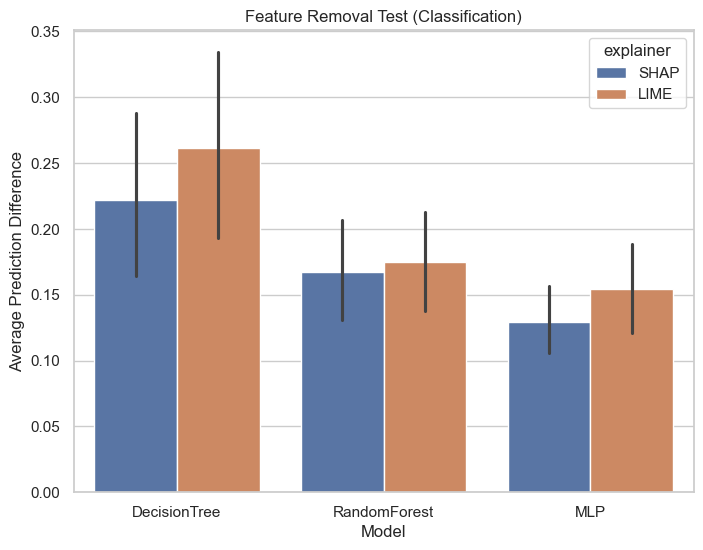

In [8]:
# Load dataset and train models
X, y = load_adult()
models, X_train, X_test, y_train, y_test = train_classification_models(X, y)

results = {
    'model': [],
    'explainer': [],
    'feature_removal_test': []
}

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Feature Removal Test
    display(Markdown("**Feature Removal Test:**"))
    feature_removal_test_results = feature_removal_test(name, model, X_train, y_train, X_test[:100], mode='classification', background_frac=0.1)
    
    for shap_result in feature_removal_test_results['shap']:
        results['model'].append(name)
        results['explainer'].append('SHAP')
        results['feature_removal_test'].append(shap_result)
    
    for lime_result in feature_removal_test_results['lime']:
        results['model'].append(name)
        results['explainer'].append('LIME')
        results['feature_removal_test'].append(lime_result)

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='feature_removal_test', hue='explainer')
plt.title("Feature Removal Test (Classification)")
plt.xlabel("Model")
plt.ylabel("Average Prediction Difference")
plt.show()


# Regression Feature Removal Experiments

DecisionTree Test MSE: 19.298
RandomForest Test MSE: 11.366
MLP Test MSE: 15.111


## Model: **DecisionTree**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

## Model: **RandomForest**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

## Model: **MLP**

**Feature Removal Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Usin

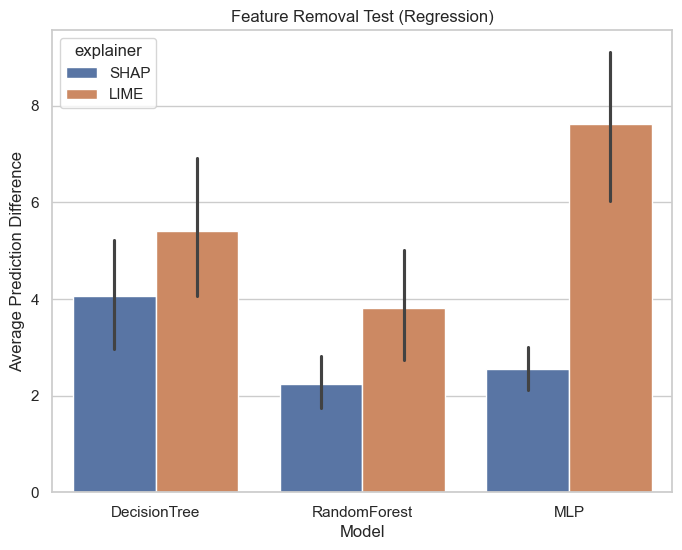

In [9]:
# Load dataset and train models
X, y = load_housing()
models, X_train, X_test, y_train, y_test = train_regression_models(X, y)

results = {
    'model': [],
    'explainer': [],
    'feature_removal_test': []
}

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Feature Removal Test
    display(Markdown("**Feature Removal Test:**"))
    feature_removal_test_results = feature_removal_test(name, model, X_train, y_train, X_test[:100], mode='regression', background_frac=1)
    
    for shap_result in feature_removal_test_results['shap']:
        results['model'].append(name)
        results['explainer'].append('SHAP')
        results['feature_removal_test'].append(shap_result)
    
    for lime_result in feature_removal_test_results['lime']:
        results['model'].append(name)
        results['explainer'].append('LIME')
        results['feature_removal_test'].append(lime_result)

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='feature_removal_test', hue='explainer')
plt.title("Feature Removal Test (Regression)")
plt.xlabel("Model")
plt.ylabel("Average Prediction Difference")
plt.show()


# Classification Stability Experiments

DecisionTree Test Accuracy: 0.796
RandomForest Test Accuracy: 0.809
MLP Test Accuracy: 0.834


## Model: **DecisionTree**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

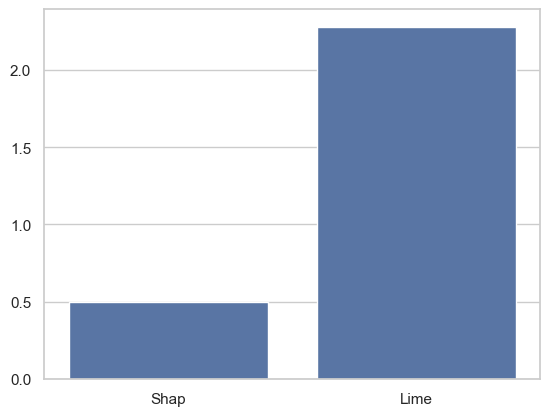

## Model: **RandomForest**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

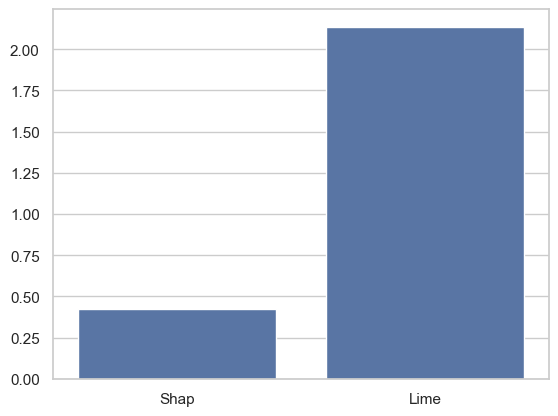

## Model: **MLP**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples

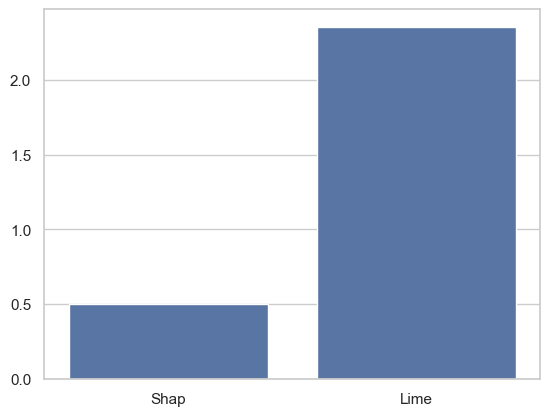

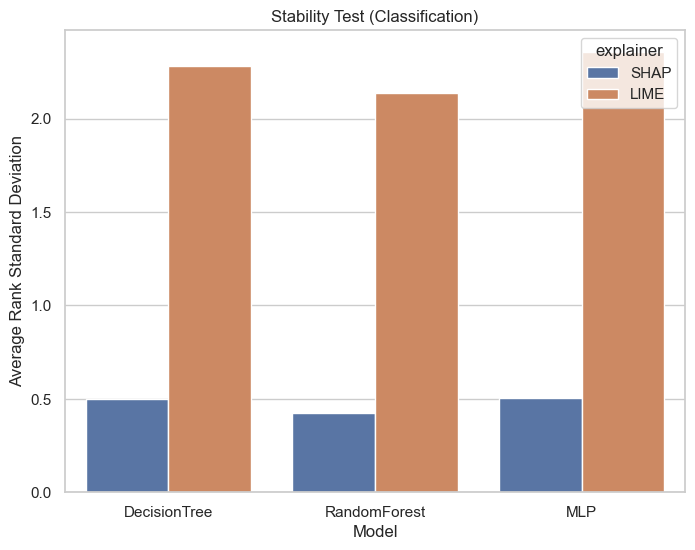

In [34]:
# Load dataset and train models
X, y = load_adult()
models, X_train, X_test, y_train, y_test = train_classification_models(X, y)

results = {
    'model': [],
    'explainer': [],
    'stability_test': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Stability Test
    display(Markdown("**Stability Test:**"))
    stability_test_results = stability_test(name, model, X_train, X_test.values[5], 100, mode='classification', background_frac=0.1)
    sns.barplot(x=['Shap', 'Lime'], y=[stability_test_results['shap'].mean(), stability_test_results['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['explainer'].append('SHAP')
    results['stability_test'].append(stability_test_results['shap'])
    
    results['model'].append(name)
    results['explainer'].append('LIME')
    results['stability_test'].append(stability_test_results['lime'])

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='stability_test', hue='explainer')
plt.title("Stability Test (Classification)")
plt.xlabel("Model")
plt.ylabel("Average Rank Standard Deviation")
plt.show()
    

# Regression Stability Experiments

DecisionTree Test MSE: 21.786
RandomForest Test MSE: 15.849
MLP Test MSE: 18.632


## Model: **DecisionTree**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

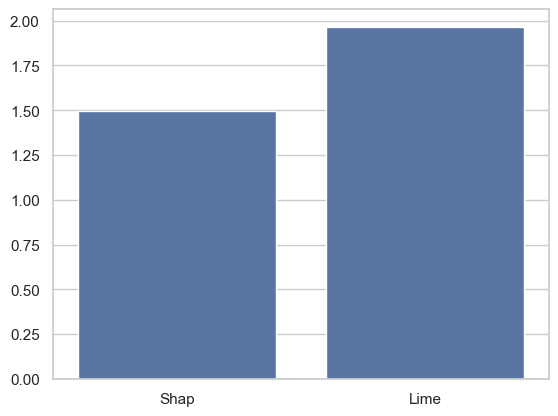

## Model: **RandomForest**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

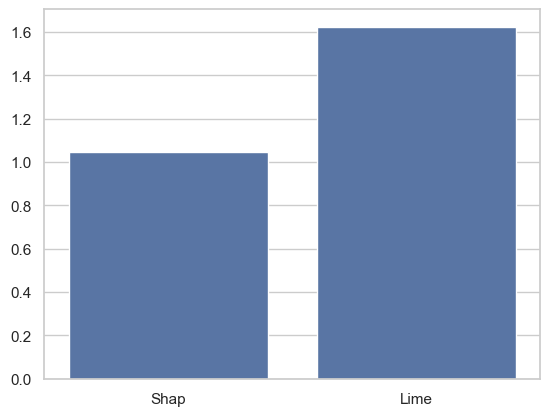

## Model: **MLP**

**Stability Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

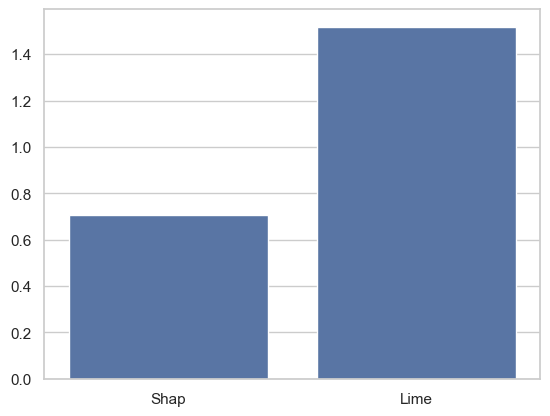

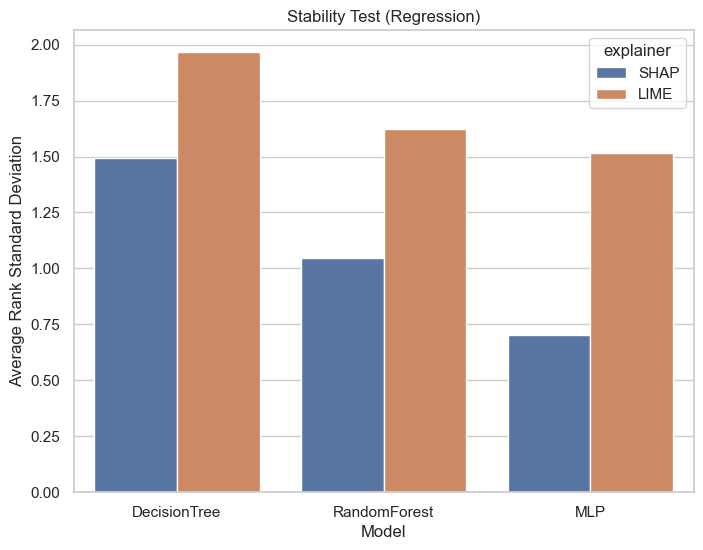

In [37]:
# Load dataset and train models
X, y = load_housing()
models, X_train, X_test, y_train, y_test = train_regression_models(X, y)

results = {
    'model': [],
    'explainer': [],
    'stability_test': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Stability Test
    display(Markdown("**Stability Test:**"))
    stability_test_results = stability_test(name, model, X_train, X_test.values[5], 100, mode='regression', background_frac=0.1)
    sns.barplot(x=['Shap', 'Lime'], y=[stability_test_results['shap'].mean(), stability_test_results['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['explainer'].append('SHAP')
    results['stability_test'].append(stability_test_results['shap'])
    
    results['model'].append(name)
    results['explainer'].append('LIME')
    results['stability_test'].append(stability_test_results['lime'])

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='stability_test', hue='explainer')
plt.title("Stability Test (Regression)")
plt.xlabel("Model")
plt.ylabel("Average Rank Standard Deviation")
plt.show()
    

# Classification PFI Comparison Experiments

DecisionTree Test Accuracy: 0.793
RandomForest Test Accuracy: 0.802
MLP Test Accuracy: 0.827


## Model: **DecisionTree**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

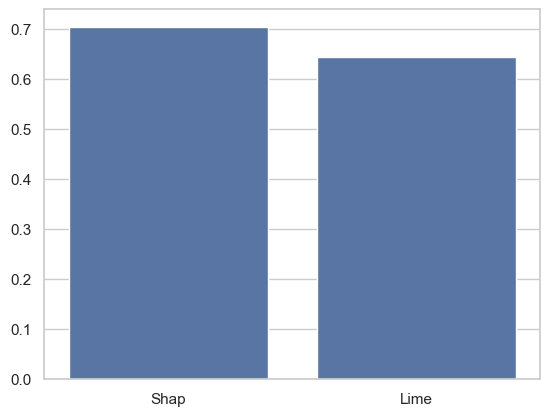

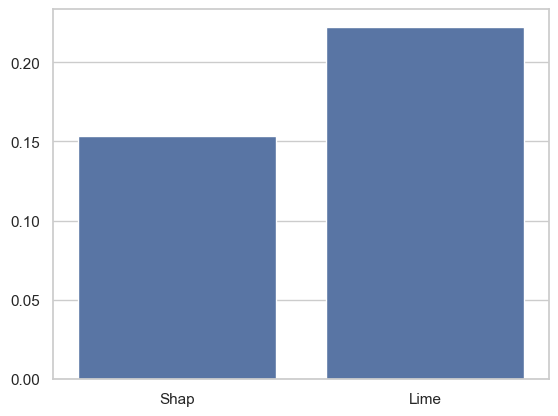

## Model: **RandomForest**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

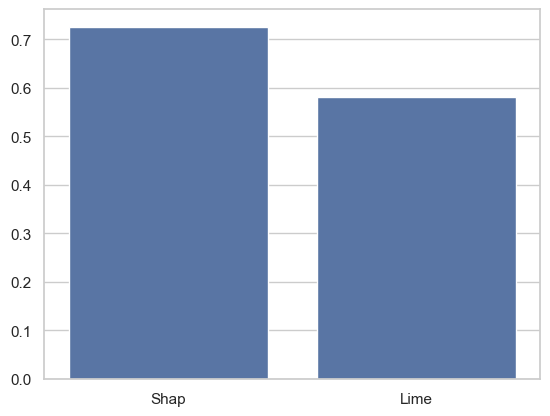

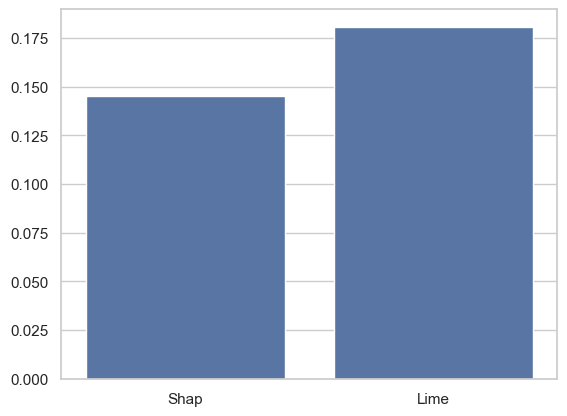

## Model: **MLP**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples

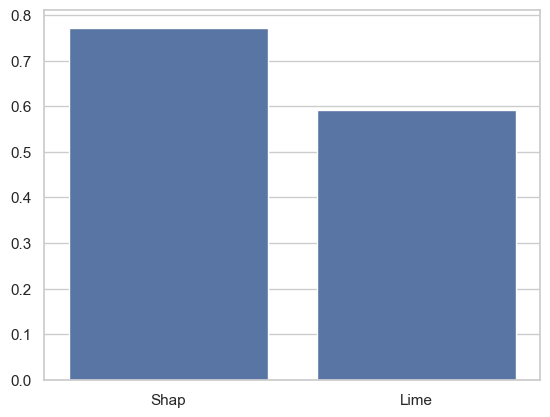

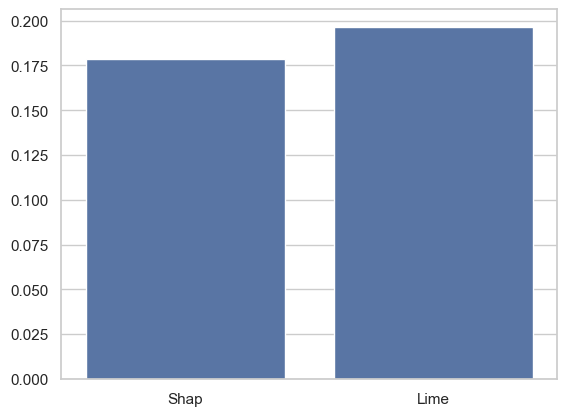

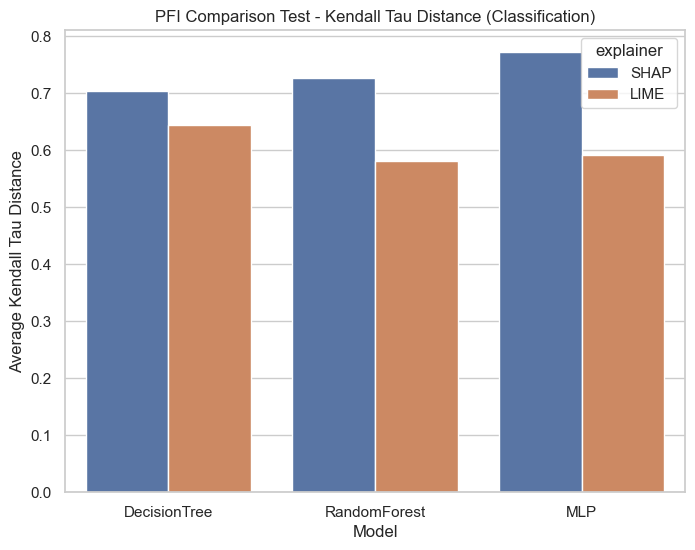

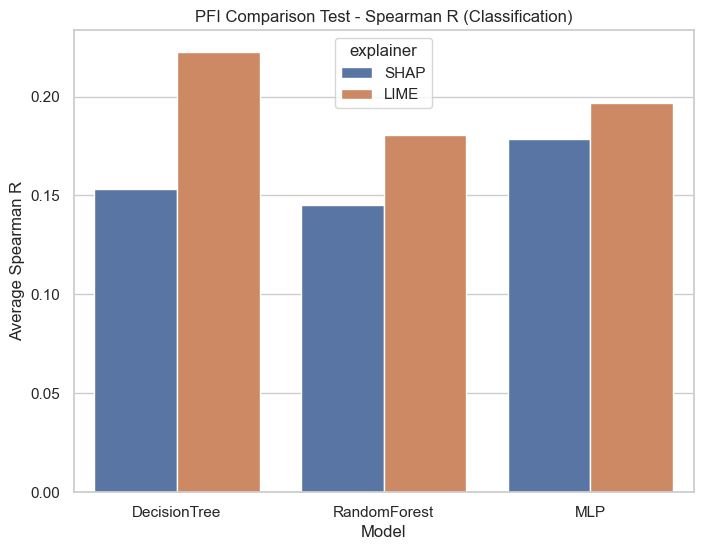

In [72]:
# Load dataset and train models
X, y = load_adult()
models, X_train, X_test, y_train, y_test = train_classification_models(X, y)

# Sample 100 random test data points
X_test = X_test.sample(100, random_state=RANDOM_STATE)
y_test = y_test.loc[X_test.index]

results = {
    'model': [],
    'explainer': [],
    'pfi_comparison_kendalltau': [],
    'pfi_comparison_spearmanr': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # PFI Comparison Test
    display(Markdown("**PFI Comparison Test:**"))
    pfi_comparison_test_kendalltau, pfi_comparison_test_spearmanr = pfi_comparison_test(
        name, 
        model, 
        X_train, 
        X_test, 
        y_test, 
        mode='classification', 
        background_frac=0.1
        )
    sns.barplot(x=['Shap', 'Lime'], y=[pfi_comparison_test_kendalltau['shap'].mean(), pfi_comparison_test_kendalltau['lime'].mean()])
    plt.show()
    sns.barplot(x=['Shap', 'Lime'], y=[pfi_comparison_test_spearmanr['shap'].mean(), pfi_comparison_test_spearmanr['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['explainer'].append('SHAP')
    results['pfi_comparison_kendalltau'].append(pfi_comparison_test_kendalltau['shap'].mean())
    results['pfi_comparison_spearmanr'].append(pfi_comparison_test_spearmanr['shap'].mean())
    
    results['model'].append(name)
    results['explainer'].append('LIME')
    results['pfi_comparison_kendalltau'].append(pfi_comparison_test_kendalltau['lime'].mean())
    results['pfi_comparison_spearmanr'].append(pfi_comparison_test_spearmanr['lime'].mean())

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='pfi_comparison_kendalltau', hue='explainer')
plt.title("PFI Comparison Test - Kendall Tau Distance (Classification)")
plt.xlabel("Model")
plt.ylabel("Average Kendall Tau Distance")
plt.show()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='pfi_comparison_spearmanr', hue='explainer')
plt.title("PFI Comparison Test - Spearman R (Classification)")
plt.xlabel("Model")
plt.ylabel("Average Spearman R")
plt.show()

# Regression PFI Comparison Experiments

DecisionTree Test MSE: 16.107
RandomForest Test MSE: 12.279
MLP Test MSE: 17.225


## Model: **DecisionTree**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

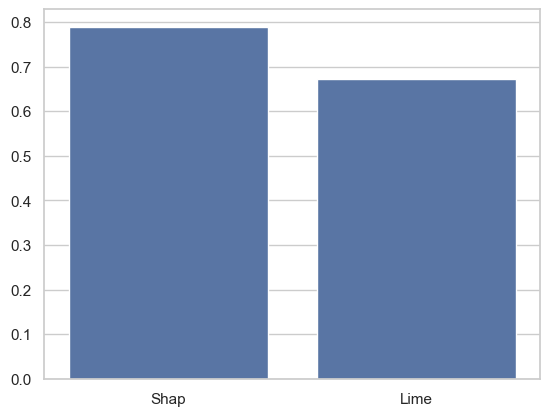

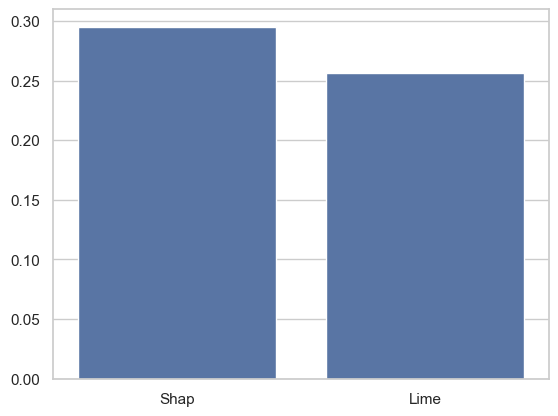

## Model: **RandomForest**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

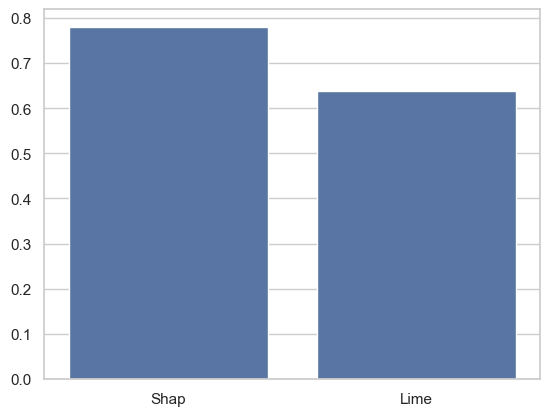

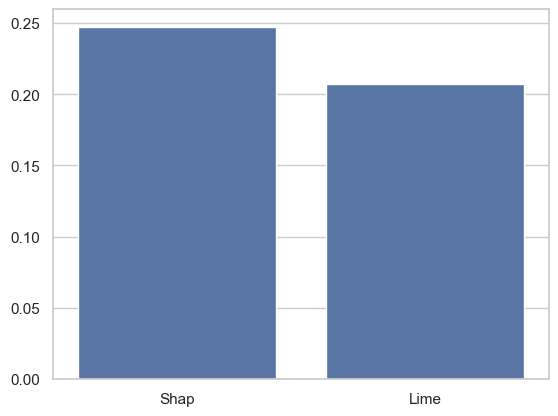

## Model: **MLP**

**PFI Comparison Test:**

  0%|          | 0/100 [00:00<?, ?it/s]

Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Usin

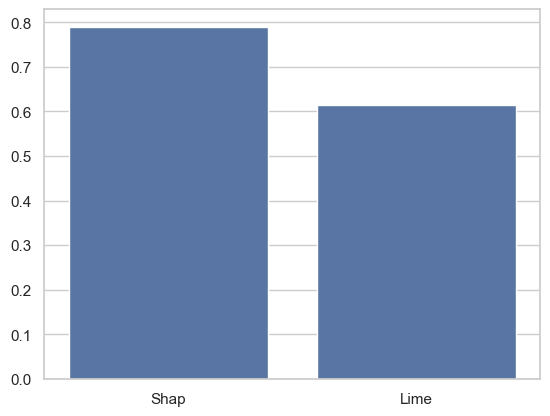

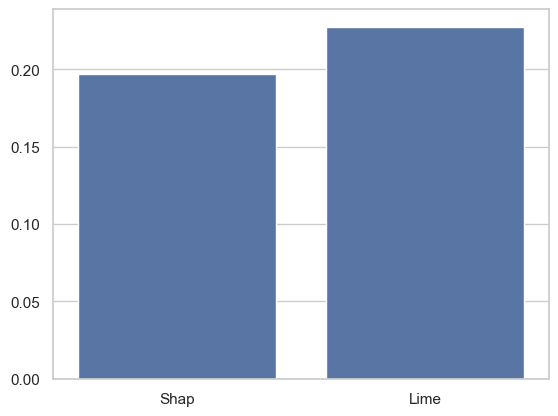

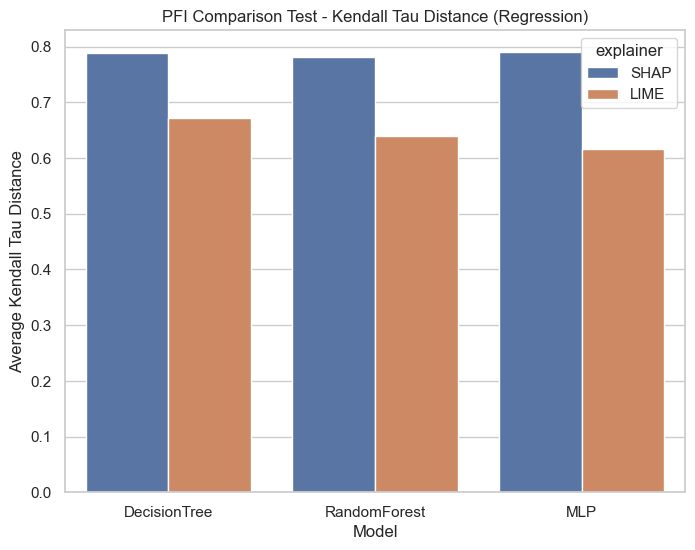

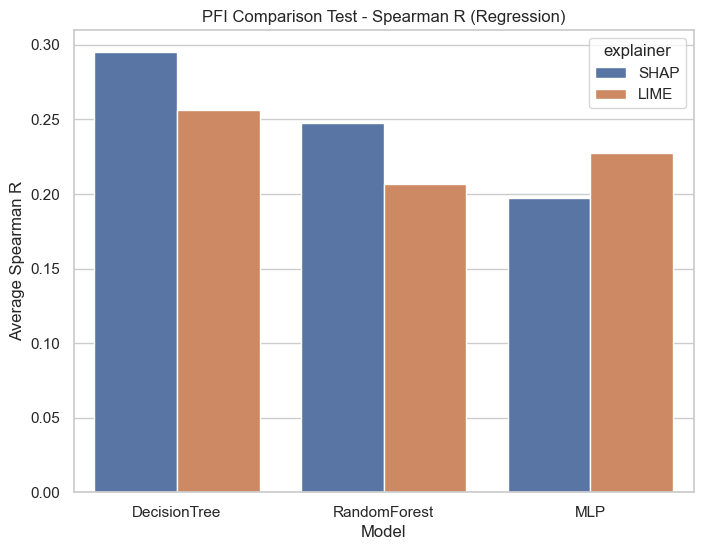

In [73]:
# Load dataset and train models
X, y = load_housing()
models, X_train, X_test, y_train, y_test = train_regression_models(X, y)

# Sample 100 random test data points
X_test = X_test.sample(100, random_state=RANDOM_STATE)
y_test = y_test.loc[X_test.index]

results = {
    'model': [],
    'explainer': [],
    'pfi_comparison_kendalltau': [],
    'pfi_comparison_spearmanr': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # PFI Comparison Test
    display(Markdown("**PFI Comparison Test:**"))
    pfi_comparison_test_kendalltau, pfi_comparison_test_spearmanr = pfi_comparison_test(
        name, 
        model, 
        X_train, 
        X_test, 
        y_test, 
        mode='regression', 
        background_frac=1.0
        )
    sns.barplot(x=['Shap', 'Lime'], y=[pfi_comparison_test_kendalltau['shap'].mean(), pfi_comparison_test_kendalltau['lime'].mean()])
    plt.show()
    sns.barplot(x=['Shap', 'Lime'], y=[pfi_comparison_test_spearmanr['shap'].mean(), pfi_comparison_test_spearmanr['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['explainer'].append('SHAP')
    results['pfi_comparison_kendalltau'].append(pfi_comparison_test_kendalltau['shap'].mean())
    results['pfi_comparison_spearmanr'].append(pfi_comparison_test_spearmanr['shap'].mean())
    
    results['model'].append(name)
    results['explainer'].append('LIME')
    results['pfi_comparison_kendalltau'].append(pfi_comparison_test_kendalltau['lime'].mean())
    results['pfi_comparison_spearmanr'].append(pfi_comparison_test_spearmanr['lime'].mean())

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='pfi_comparison_kendalltau', hue='explainer')
plt.title("PFI Comparison Test - Kendall Tau Distance (Regression)")
plt.xlabel("Model")
plt.ylabel("Average Kendall Tau Distance")
plt.show()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='model', y='pfi_comparison_spearmanr', hue='explainer')
plt.title("PFI Comparison Test - Spearman R (Regression)")
plt.xlabel("Model")
plt.ylabel("Average Spearman R")
plt.show()